In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
from sklearn.cluster import k_means, kmeans_plusplus, KMeans
from sklearn.decomposition import PCA
import os
from keras import utils 

# Load the data
IN_COLAB = 'google.colab' in str(get_ipython())

if IN_COLAB:
    diabetes_url = "https://github.com/AkeemSemper/ML_for_Non_DS_Students/raw/main/data/diabetes.csv"
    wine_url = "https://github.com/AkeemSemper/ML_for_Non_DS_Students/raw/main/data/Wine.csv"
    df_path = keras.utils.get_file("diabetes.csv", diabetes_url)
    wine_path = keras.utils.get_file("wine.csv", wine_url)
    df = pd.read_csv(df_path)
    wine = pd.read_csv(wine_path)
else:
    df = pd.read_csv("../data/diabetes.csv")
    wine = pd.read_csv("../data/Wine.csv")

df.drop(columns={"Outcome"}, inplace=True)

# Clustering

Clustering algorithms are a part of machine learning that attempts to group, based on the features in the dataset, records into "clusters" of similar examples. Clustering is unsupervised - we don't know which groupings we'll end up with in advance (in contrast to something like logistic regression, where we know going in what the resulting classes are, we are just trying to fit each records into one of those groups)

## Unsupervised Learning

The clustering that we will look at here is an example of unsupervised learning, or machine learning models that do not have predefined labels like we had in classifications. Instead, the model will try to find patterns in the data and group them together based on the similarities in the data itself. We don't start knowing the possible outcomes, we give the data to the algorithm and it tells us what the groupings should be. 

### Clustering and K-Means

Clustering is simple in concept, the goal is to group our data points into clusters, or groups of records that are the most similar to each other, and the most dissimilar to the records in other clusters. The main difference from classification is that we don't know what the clusters are going to be in advance. We feed in data, normally set the number of separate groups we want, and the algorithm figures out what the groups should be.

![Clustering](../images/clustering.png "Clustering")

Clustering algorithms are common in the real world, in several applications. They are very helpful when we don't really know the end results that we are expecting. Some common applications of clustering algorithms are:
<ul>
<li> Customer segmentation - grouping customers into different groups based on their purchasing patterns, demographics, etc.
<li> Medical diagnosis - grouping patients into different groups based on their symptoms, etc.
<li> Social network analysis - grouping people into different groups based on their social connections, etc.
<li> Anomaly detection - looking for things that <i>don't</i> fit into the other groups well, as they may be things to investigate. 
</ul>

Clustering logic is also commonly used in conjunction with other algorithms. For example, we can use clustering to group our data into different groups, and then use classification on each group to get a more accurate result. We can also use it to help with smarter imputation. 

### My First Cluster! Building to K-Means Clustering

We can cluster data using K-Means, first, we can make some simple data to cluster. We will use the make_blobs function to make 300 samples with 2 features, X and Y, which fall into 4 distinct clusters. We will then plot the data to see what it looks like.

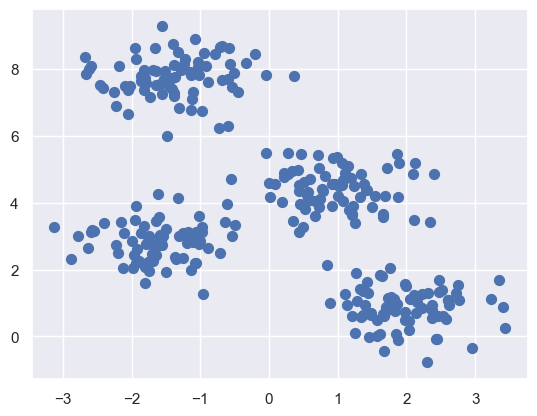

In [2]:
from sklearn.datasets._samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50)

##### Visually Clustering our Blobs

We can look at the dummy data plotted above and it is pretty clearly broken up into 4 blobs that we can identify visually pretty easily with my Picasso level artistic skillz. 

![Visual Clustering](../images/visual_clusters.png "Visual Clustering")

Each group of points that I have circled is one "cluster" - here we eyeballed it; clustering algorithms will try to do this automatically by finding the points that are <b><i>most similar</i></b> to each other based on their features, which are X and Y here. 

#### Clustering with K-Means

We can use kmeans to create clusters similar to the above, but with some slightly more formal clustering than my freehand lines. Clustering works by finding these blobs of similar points, and grouping them into "like" groups similarly to how we do by eye. 

##### K-Means Clusters

The mechanics of this are very simple, we'll use the KMeans clustering function very similarly to how we use any model in scikit-learn. We'll create a KMeans object, and then fit it to our data, then generate predictions for each point in the data - or assign it to a cluster. The "Cluster" column that we see below is which of the 4 clusters that we saw above that each point is assigned to. The unsupervised factor here is that we don't have any idea which cluster is which, the alogrithm will assign them to the clusters that it thinks are most similar, but which group is "1', which is "2", etc. is unknown to us going in.

In clustering we don't really have the train/test split, because we don't have anything to test against. We just have the data, and we want to find the clusters - there's not right or wrong answer. 

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
clusters = kmeans.predict(X)

## Create DataFrame with cluster labels for display
testdf = pd.DataFrame(X)
testdf['Cluster'] = clusters
testdf.head()

,0,1,Cluster
0,0.836857,2.136359,1
1,-1.413658,7.409623,2
2,1.155213,5.099619,3
3,-1.018616,7.814915,2
4,1.271351,1.892542,1


##### Labels

Since our model was fitted to our data, we can shortcut the prediction step and just get the label with the labels_ attribute. This will give us the cluster that each point was assigned to, just as the prediction step did above. When we are using all of our data for fitting, this is exactly the same. 

<b>Note:</b> One important thing to remember in clustering is that the labels that the clustering algorithm assigns is just a number, it has no meaning outside of differentiating the clusters. So being in cluster 1 or 0 doesn't equate to True/False or any other external label. Which clustered group gets which label is 100% arbitrary. 

In [4]:
clusters2 = kmeans.labels_

testdf2 = pd.DataFrame(X)
testdf2['Cluster'] = clusters2
testdf2.head()

,0,1,Cluster
0,0.836857,2.136359,1
1,-1.413658,7.409623,2
2,1.155213,5.099619,3
3,-1.018616,7.814915,2
4,1.271351,1.892542,1


##### Plot Clusters

We can now plot the clusters that we have created, along with the center point of each cluster. 

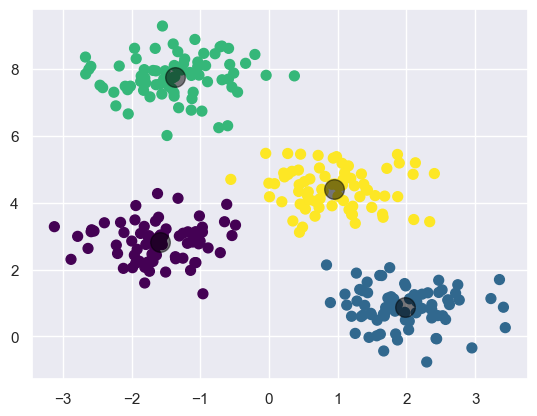

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=clusters, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)


## Creating K-Means Clusters and Inertia

Much like logistic regression and gradient descent, clustering relies on an iterative algorithm to find the correct clustering. In this case the algorithm attempts to minimize a metric called inertia. Inertia is the within-cluster sum-of-squares, roughly the compactness of each cluster. 

$ \sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)  $

This calculation is just the sum of squares distance of each point to the center of that group. The algorithm is pretty simple as well:
<ul>
<li> Start with a random set of centroids.
<li> Assign each point to the closest centroid. 
<li> Calculate the inertia (above).
<li> Move the centroids to the center of the points that are assigned to that centroid. 
<li> Recalculate the inertia.
<li> Repeat this process until the inertia stops changing.
</ul>

![K-Means](../images/kmeansMath.png "K-Means")

![K-Means Process](../images/kmeansViz.png "K-Means Process")

While using this metric of inertia generates "tight" groupings, there are a few concerns:
<ul>
<li> The distance from the center point is radial. If there is an irregular pattern to the data distribution, this may not make sense. 
<li> When using high dimension data, the distances can inflate. Using an algorithm to reduce dimensionality like PCA can help this. 
</ul>

The cluster centers are randomly placed, then the inertia is calculated and the points are updated. This process uses something called Expectation Maximization, but the effect is exactly as though we were doing gradient descent with a cost function - eventually we converge on the solution. One issue is that, like with some gradient descent problems, we can have the optimized solution fall into a local minima, not the global solution. To combat this the kMeans built into sklearn defaults to using 10 iterations, in each one the starting point of the centroids is different, so we can likely avoid this. We can also call a parameter called "init" which changes the starting placement of the centroids from random to "k-means++" which looks at the data to generate smart starting points to speed convergence on a solution, and avoid local minima. 

We don't need to delve super deep into the math of how things work here, as long as we understand that the algorithm iteratively pursues the best solution, or the lowest inertia, we are good. 

### Clustering Example

Using real data, we'll cluster the diabetes havers/not havers based on their metrics. 

In [6]:
#Load Data

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


### Scale and PCA Data

Here we'll scale the data and also run it through PCA so we can project it into 2D for visualization. Our data is currently in 8 dimensions - we can't really draw that effectively. Using PCA to make visualization easier for high dimension data is pretty common. For example, song data is analyzed by people like Spotify, and they produce visualizations to illustrate aspects of their analysis:

![PCA Visualization](../images/pca_cluster_songs.png "PCA Visualization")

These projections down to 2 dimensions for visualizing data are hit-and-miss in terms of how "good" they are at showing the data. There is obviously a lot of information lost in the process, but the alternative is not being able to visualize the data at all. When looking at clustering, these visualizations are pretty common, as seeing the different clusters is something you probably want to be able to do.

#### What is PCA?

Principal Component Analysis, or PCA, is a technique used to reduce the dimensionality of the data. It does this by finding the principal components of the data, which are the directions along which the data varies the most. PCA basically breaks apart our data, then recombines it so that each feature is made up of a combination of the information in the original features. This can allow us to capture more of the important information in fewer features.

In [7]:
from sklearn.preprocessing import MinMaxScaler
X_clus = MinMaxScaler().fit_transform(df)
X_c = PCA(2).fit_transform(X_clus)

### Plot Clusters

We need to specify the number of clusters to produce. We can plot several selections of k and see visually how well that fits our data. 

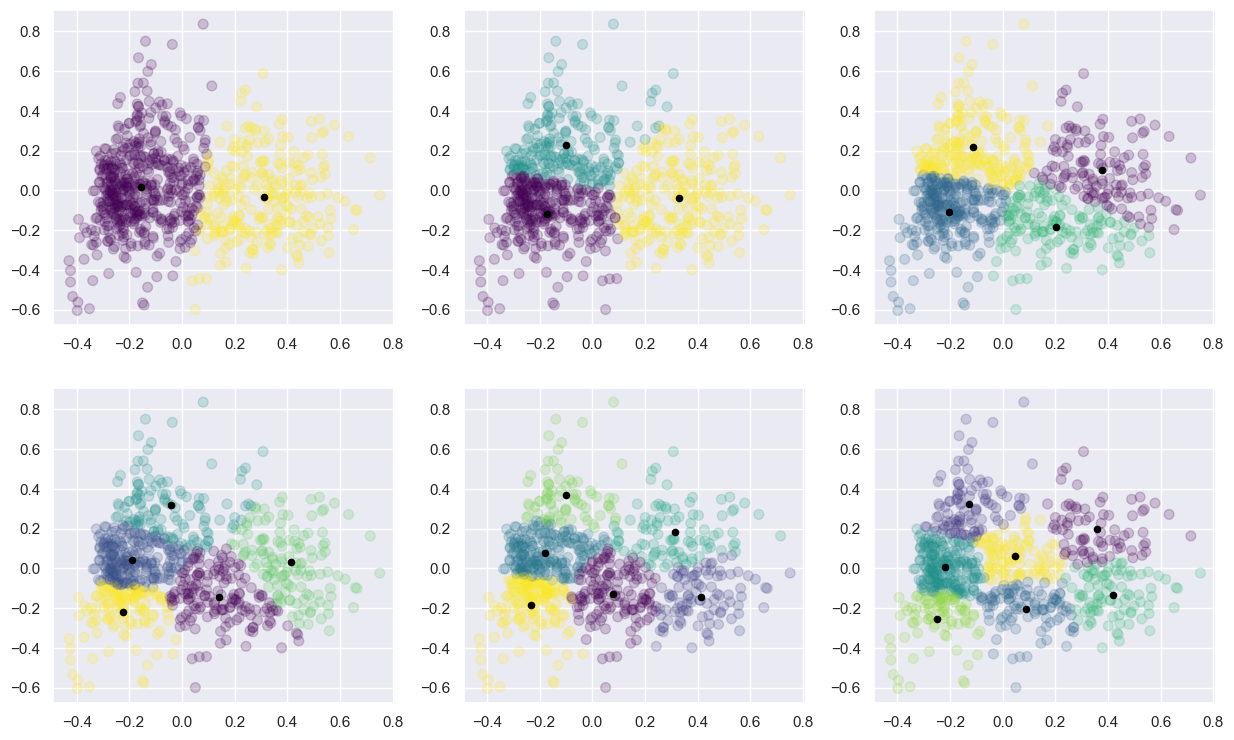

In [8]:
nc = [2,3,4,5,6,7]
fig, ax = plt.subplots(2, 3, figsize=(15, 9))
row = 0
col = 0
for n in nc:
    kmeans = KMeans(n_clusters=n, max_iter=1000, n_init='auto')
    kmeans.fit(X_c)
    y_kmeans = kmeans.predict(X_c)
    ax[row][col].scatter(X_c[:,0], X_c[:,1], c=y_kmeans, s=50, cmap='viridis', alpha=.2)
    centers = kmeans.cluster_centers_
    #print(centers)
    ax[row][col].scatter(centers[:, 0], centers[:, 1], c='black', s=20)
    col += 1
    if col >= 3:
        col = 0
        row += 1
plt.show()


## How Many Clusters Should I Have?

There are a couple of ways to determine how many clusters you should have. The most common is the "elbow" method, which looks at the inertia of the clusters as we increase the number of clusters. The idea is that as we increase the number of clusters, the inertia will decrease, but at some point the decrease will slow down. This is the "elbow" point, and is the point where we should stop increasing the number of clusters.

Doing this is pretty simple, we just need to test a range of clusters and plot the inertia. If dealing with large data, this can be computationally expensive, so we may want to limit the range of clusters we test or use a data sample. 

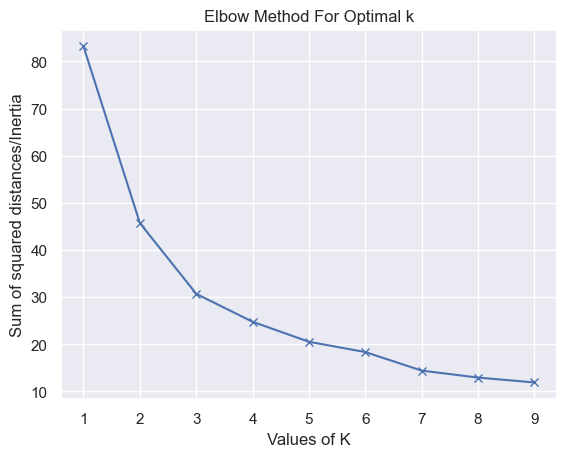

In [9]:
# Elbow Method
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, n_init="auto")
    kmeans.fit(X_c)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances/Inertia") 
plt.title("Elbow Method For Optimal k")
plt.show()

### Example - Clustering Digits

We can try to cluster the digits that we looked at previously. We can try to group the drawings into digits without using their labels. 

In [10]:
from sklearn.datasets import load_digits
digits = load_digits()
Xp = digits.data
yp = digits.target

For this we know that we'll need 10 clusters (think about this number a bit...), so that part is easy. 

In [11]:
num_clust = 10

kmeans = KMeans(n_clusters=num_clust, n_init="auto")
clusters = kmeans.fit_predict(Xp)
kmeans.cluster_centers_.shape


(10, 64)

#### Plot the "Average" Digit

We can plot the center of each cluster. These centers are each 64 dimension points - one for each feature. The center is the middle of each cluster, so it isn't the "most average" one of the images that we started with, it is the average of all the pixels of each drawing of that number. Or more accurately the average of all the pixels of each digit that got clustered together - correctly or incorrectly. We are creating a new image, the one that is the actual average of all the images in that cluster.

This concept is something that we'll use more later - once we fit a clustering algorithm to our data, the model "knows" what each cluster "looks like".

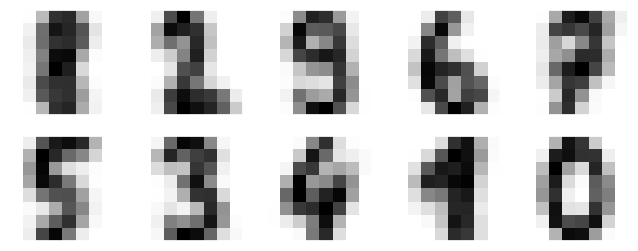

In [12]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

### Digits are Grouped!

We don't know the classes going in, but our clustering has managed to group the digits pretty well! 

#### But What ARE the Predictions?

Clustering doesn't know anything about the labels of our digits, all it is doing is grouping together the similar pieces of data and giving each group some arbitrary label - group 1, group 2, etc... To figure out which are correct or incorrect we need to label each group. To do so, we'll take the mode, or most frequent, from the set of labels. We can then check an entire group against the correct label. This is a key characteristic of unsupervised learning - we aren't putting things into classes that we know, like a classification model, we are looking <i>only</i> at the data, and putting that data into groups, each of which we don't know what that group is, only that the elements in it are similar. 

We generally don't know labels at when clustering, but since this is a trial run, we do. We can pull those in to check our accuracy. This isn't a standard action, we are just doing a check. 

In [13]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(yp[mask])[0]

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(yp, labels)

0.796883695047301

Text(110.44999999999997, 0.5, 'predicted label')

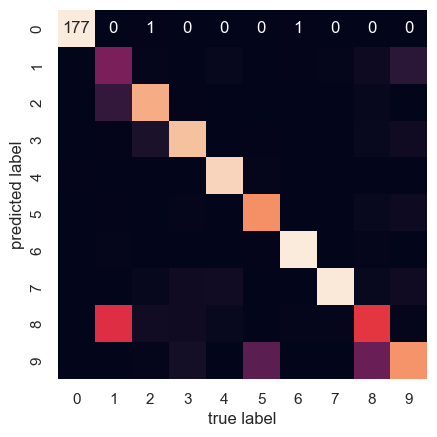

In [15]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

### Results

We didn't do too badly! Most errors are what we'd expect, especially with such low resolution digits. Things that are similar, like skinny 8s and 1s, or 8s and 9s are often confused, other than those we are quite accurate. 

But can we do better...

## Exercise - Clustering Wine

Cluster the wine. Customer_Segment is the target, so we'll drop that for clustering. 
<ul>
<li> Project a plot with PCA. 
<li> Use KMeans to cluster the data.
</ul>

In [16]:

wine.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1
